In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022

本文件仿真有泵浦光补偿的情况，假设有未知参数，进行逆向研究

@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1, torch"""
import deepxde as dde
import numpy as np
import pandas as pd
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma
from scipy.special import lambertw
import yaml
#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)
CopyFlag = 0

## 定义模型变量
#q_var = dde.Variable(10.0)
## 单位统一至cm，定义各个参数
#D = 0.695
D_var = dde.Variable(0.001)

Rsd = 13.457 #1/s


#Rwall = 2.654 # 泡壁碰撞的参数是不是错啦
Rwall = 6.4424 #1/s
Rrel = 45.669 #1/s
rpump = 0.75
q = 5
#q_var = dde.Variable(0.2) ## 使用乘以，试试
#qlambda_real = 0.5
rcell = 1.5

#Rrel = Rsd + (q+q_lambda)*Rwall
I = 25*1e-3*1e4 # kg*(cm)^2/s^3
T = 170
k1 = 10**(-20)*10**8 # kg*cm^4/s^2
k2 = 10**(-17)*10**4 # cm^2
k3 = 1 # cm^-3
sigm = 2.34601*10**(-13) # cm^2

#n = k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))
n = 3.7405E13 #1/m³

with open('./Config/train_20220715-Var.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config)


Using backend: pytorch



{'ConfigDate': datetime.date(2022, 7, 27), 'CSVPath': './result/Variant/Inverse_weights', 'CSVRoot': './result/Variant/', 'LightIntensity': 25, 'Temperature': 170, 'LossWeights': [1, 10, 100], 'CopyFlag': [1, 2, 3], 'NetDepth': [4], 'NetWidth': [120], 'TrainEpoch': 80000, 'Rsd': [11.505, 12.448, 14.019, 12.526, 13.457, 15.017], 'Rwall': [10.379, 10.826, 11.285, 6.1763, 6.4424, 6.716], 'Rrel': [63.398, 66.576, 70.446, 43.408, 45.669, 48.597], 'D': [0.87449, 0.89313, 0.9119, 0.68068, 0.69519, 0.7098], 'n': ['2.2432E13', '3.7405E13', '6.0952E13', '2.2432E13', '3.7405E13', '6.0952E13']}


In [3]:
k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))

37405282806931.125

In [4]:
def gen_traindata():
    #data = np.load("../dataset/Lorenz.npz")
    filename_3D = './COMSOL_data/D_unknown.csv'
    #df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
    df_3D = pd.read_csv(filename_3D, header=9, names=['x', 'y', 'z', 'Pz'])
    point_num = 20000
    axis_3D_x = np.asarray(df_3D['x'])[:point_num]
    axis_3D_y = np.asarray(df_3D['y'])[:point_num]
    axis_3D_z = np.asarray(df_3D['z'])[:point_num]
    axis_3D_Pz = np.asarray(df_3D['Pz'])[:point_num]
    axis_3D_axis = np.stack((axis_3D_x, axis_3D_y, axis_3D_z), axis=1)
    
    return axis_3D_axis, axis_3D_Pz.reshape(-1, 1)



200
237.42250856458008


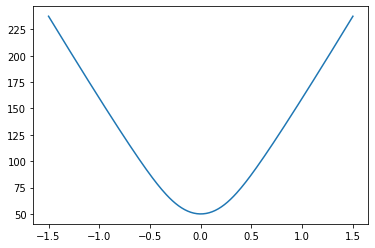

In [5]:
## 读取COMSOL生成数据
filename_Rop = './COMSOL_data/D_inverse_Rop0.csv'
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df_Rop = pd.read_csv(filename_Rop, header=8, names=['x','y','z','Rop'])
Rop_raw = df_Rop['Rop']
z_axis = df_Rop['z']
plt.plot(z_axis,Rop_raw)
print(len(Rop_raw))
from scipy.interpolate import interp1d
#z_axis = np.linspace(-1.5, 1.5, 300)
Func_Rop = interp1d(z_axis, Rop_raw)
print(Func_Rop(1.5))

In [6]:
## 自定义callbacks, 每1000epoch，打印变量的值

from deepxde.callbacks import Callback
import os
import pandas as pd

class printVariable(Callback):
    def __init__(self, var_list, period=100, csvPath='Variable.csv', precision=4):
        super().__init__()
        self.var_list = var_list if isinstance(var_list, list) else [var_list]
        self.period = period
        self.precision = precision
        self.csvPath = csvPath

        #self.file = sys.stdout if filename is None else open(filename, "w", buffering=1)
        self.value = None
        self.epochs_since_last = 0
        self.model = None
        self.epoch_num = 0
    
    def on_train_begin(self):

        self.value = [var.detach().item() for var in self.var_list]
        df = pd.DataFrame({
            'Epoch':self.epoch_num,
            'Var D': self.value[0]
        }, index=[0])
        df.to_csv(self.csvPath, index=False, mode='w', sep=',', columns=['Epoch', 'Var D'])
        print(
            'Variable pred',
            self.value[0]
        )
    
    def on_epoch_end(self):
        self.epochs_since_last += 1
        self.epoch_num +=1
        if self.epochs_since_last >= self.period:
            self.epochs_since_last = 0
            self.saveVariable()
            
    def saveVariable(self):
        self.value = [var.detach().item() for var in self.var_list]
        saveVar = np.array([self.epoch_num, self.value[0]])
        df = pd.DataFrame({
            'Epoch':self.epoch_num,
            'Var D': self.value[0]
        }, index=[0])
        df.to_csv(self.csvPath, index=None, mode='a', sep=',', columns=['Epoch', 'Var D'], header=False)
#         print(
#             'Variable pred',
#             self.value[0]
#         )
    def get_value(self):
        """Return the variable values."""
        return self.value

   
class saveModel(Callback):
    def __init__(self, saveDir, saveName, period=5000, filename=None, precision=2):
        super().__init__()
        #self.var_list = var_list if isinstance(var_list, list) else [var_list]
        self.period = period
        self.precision = precision

        #self.file = sys.stdout if filename is None else open(filename, "w", buffering=1)
        self.value = None
        self.epochs_since_last = 0
        self.model = None
        self.modelNum = 0
        self.saveDir = saveDir
        self.saveName = saveName
        if not os.path.exists(self.saveDir):
            os.makedirs(self.saveDir)
        
    def set_model(self, model):
        if model is not self.model:
            self.model = model
            self.init()    
            
    def on_epoch_end(self):
        self.epochs_since_last += 1
        if self.epochs_since_last >= self.period:
            self.modelNum += 1
            self.epochs_since_last = 0  
            savePath = os.path.join(self.saveDir, self.saveName+str(self.modelNum)+'.pt')
            #print(self.model.net.state_dict())
            checkpoint = {
                "model_state_dict": self.model.net.state_dict(),
                "optimizer":self.model.opt.state_dict()
            }
            torch.save(checkpoint, savePath)          
            print('Save model....')

class loadModel(Callback):
    def __init__(self, loadPath):
        super().__init__()
        #self.var_list = var_list if isinstance(var_list, list) else [var_list]
        self.loadPath = loadPath
        
    def set_model(self, model):
        if model is not self.model:
            self.model = model
            self.init()    
            
    def on_train_begin(self):
        checkpoint = torch.load(self.loadPath)
        self.model.net.load_state_dict(checkpoint["model_state_dict"])
        #self.model.opt.load_state_dict(checkpoint["optimizer"])
        print('Load model successful')
        
        

In [7]:
def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
#     x_arr = x.eval(session=sess)
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj

    plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
    plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))
    Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
    Rop0_z = np.asarray(Rop0_z)    
    
    Rop = Rop0_z * np.exp(-2*(x**2+y**2)/rpump**2)
    Rop = torch.from_numpy(Rop).cuda()
# ## 方法：通过COMSOL采样计算Rop    
#     Rop_z = Func_Rop(z)    
#     Rop = Rop_z * np.exp(-2*(x**2+y**2)/rpump**2)
#     Rop = torch.from_numpy(Rop).cuda()
    #Rop = Rop0
    
    return -D_var*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/q+Rwall)*y_in - Rop/q

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    #Rop = Rop0 * np.exp(-2*(x**2+y**2)/rpump**2)
    
    plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
    plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))
    Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
    Rop0_z = np.asarray(Rop0_z)    
    
    Rop = Rop0_z * np.exp(-2*(x**2+y**2)/rpump**2)
    #Rop = torch.from_numpy(Rop).cuda()

#     Rop_z = Func_Rop(z)    
#     Rop = Rop_z * np.exp(-2*(x**2+y**2)/rpump**2)
    
    second_term = np.sqrt(1/2*np.abs(Rop*D_var.detach().cpu().numpy()))
    second_term = torch.from_numpy(second_term).cuda()
    #Rop = torch.from_numpy(Rop).cuda()
    # tranfer back to torch.tensor
    #Rop = torch.from_numpy(Rop).cuda()
#     x = torch.from_numpy(x).cuda()
#     y = torch.from_numpy(y).cuda()
#     z = torch.from_numpy(z).cuda()
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    return (D_var/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*second_term)


# for lossWeight in config['LossWeights']:
#     geom = dde.geometry.Sphere([0, 0, 0], rcell)
#     #bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#     #bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
#     bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC


#     ## 添加变量参数约束

#     # Get the train data
#     observe_axis, ob_pz = gen_traindata()
#     print('Pz shape ', ob_pz.shape)
#     observe_points = dde.icbc.PointSetBC(observe_axis, ob_pz, component=0)

#     data = dde.data.PDE(geom, bloch_pde,\
#                         [bc, observe_points],\
#                         num_domain=20000, num_boundary=2000,\
#                        anchors=observe_axis)

#     net = dde.nn.FNN([3] + [120] * 4 + [1], "tanh", "Glorot normal")
#     # net.apply_output_transform(
#     #     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
#     # )

#     model = dde.Model(data, net)
#     model.compile("adam", lr=1e-4, external_trainable_variables=[D_var],loss_weights=[1,1,lossWeight])
#     #losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
#     print_variable = printVariable([D_var], csvPath=config['CSVPath']+'{}.csv'.format(lossWeight))
#     saveModelCall = saveModel('./model/inverse/', 'Dpred_W{}_'.format(lossWeight))
#     #loadModel_call = loadModel('pre1.pt')
#     # losshistory, train_state = model.train(iterations=60000, callbacks=[variable])
#     # dde.saveplot(losshistory, train_state, issave=True, isplot=True)
#     losshistory, train_state = model.train(epochs=config['TrainEpoch'], callbacks=[print_variable, saveModelCall])
#     dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [8]:
# ## 读取dat文件，并绘图

# q_datFile = pd.read_csv("variables_D.dat", header=None, usecols=[0])

# #q_data = np.asarray(q_datFile)
# #plt.plot(q_data)
# q_data = []
# for i in q_datFile[0]:
#     q_data.append(float(i.split('[')[1].split(']')[0]))
    
# ## 正确的参考值在0.18附件    
# plt.plot(q_data)    

In [11]:
def Sample_PlaneData(z=0, sample_num = 200):
    radius_z = np.sqrt(rcell**2 -z**2)
    sample_data = []    

    for theta in np.linspace(0, 2*np.pi, sample_num):
        for r_pow in np.linspace(0, radius_z**2, sample_num):
            x = np.sqrt(r_pow) * np.cos(theta)
            y = np.sqrt(r_pow) * np.sin(theta)
            sample_data.append((x, y, z)) # 200*200 = 40000个采样点

    sample_data = np.asarray(sample_data, dtype=np.float32
                            )
    return sample_data

SampleAxis = Sample_PlaneData()
SampleDf = pd.DataFrame(SampleAxis).to_csv('axis_position.csv',index=None,header=False)
SampleAxis.shape

(40000, 3)

In [16]:
geom = dde.geometry.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC


## 添加变量参数约束

# Get the train data
observe_axis, ob_pz = gen_traindata()
print('Pz shape ', ob_pz.shape)
observe_points = dde.icbc.PointSetBC(observe_axis, ob_pz, component=0)

data = dde.data.PDE(geom, bloch_pde,\
                    [bc, observe_points],\
                    num_domain=20000, num_boundary=2000,\
                   anchors=observe_axis)

net = dde.nn.FNN([3] + [120] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
loadPath = 'Dpred_weights1000.pt'
checkpoint = torch.load(loadPath)
model.net.load_state_dict(checkpoint["model_state_dict"])
#self.model.opt.load_state_dict(checkpoint["optimizer"])
print('Load model successful')

Pz shape  (20000, 1)


/usr/local/lib/python3.6/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+20002=20002. 
  total_n_samples))


Compiling model...
'compile' took 0.000865 s

Load model successful


/usr/local/lib/python3.6/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  total_n_samples))


In [17]:
predPolar = model.predict(SampleAxis)
predDf = pd.DataFrame(predPolar).to_csv('predPolar.csv',index=None,header=False)


In [15]:
SampleAxis.shape

(40000, 3)